In [79]:
from flowstar.reachability import Poly, Reach
load('interval_signals.py')
from matplotlib.pyplot import figure
import warnings
warnings.filterwarnings("ignore")

# Annual review
Thomas Wright

**To this point**:
    
- Extension of bond-calculus: process algebra with:

    - Continuous and stochastic semantics.

    - Functional rates via *affinity patterns*.

- Paper (SASB 2018) modelling gene regulation at network and molecular levels.

- Technical paper presenting core language and continuous semantics (currently on ArXiV).
    
**Ongoing**:

- Focus on extending ${\mathcal{L}\mathcal{BC}}$ using techniques from Hybrid Automata reachability analysis (flow*).


 - **Overall aim**:
     - Investigate integration of Taylor model flowpipe construction with temporal logic to model check contextual properties.

 - **General approach**
     - Signal monitoring over flow* flowpipes (with three-valued signals).

 - **Some challenges**:
     - *Uncertain contextual properties*:
     $$([a, b]\,X \mathrel\parallel [c,d]\,Y) \triangleright \varphi$$
     
     - *Differential contexts*:
     $$([a, b]\,X \mathrel\parallel [c,d]\,Y) \triangleright_{\partial} \varphi$$
     
     - *More general constrained contexts*:
     $$([a,b]\,X \parallel [c,d]\,Y : \psi) \triangleright \varphi$$


## Current progress

 - Implementing three-valued signals (using Python)
 
 - Signal monitoring over flowpipes (using interval Newton-Raphson iteration)
 
 - Wrapping flow* C++ API (using Cython)
 
 - Methods for model checking context operators


## A simple example:

<table style="width:100%; text-align: center !important;"> 
    <tr>
        <th>ODE:</th>
        <th>System:</th>
    </tr>
    <tr>
        <td>$\frac{\mathrm d [\mathrm{X}]}{\mathrm dt} = - [\mathrm{Y}]$</td>
        <td>$\mathrm X \triangleq x.(X|Y)\qquad\mathrm{Y}\triangleq y.(Y|X)$</td>
    </tr>
    <tr>
        <td>$\frac{\mathrm d [\mathrm{Y}]}{\mathrm dt} = [\mathrm{X}]$
        </td>
        <td>
            <img class="center" style="height: 4ex" src="images/affinity-circular.png" />
        </td>
    </tr>
</table>

Initial condition: $[\mathrm X]_0 \in [4,5],\; [\mathrm Y]_0 \in [1,2]$

In [80]:
variables = ['x', 'y']
odes      = [Poly(-1, 'y', 1, variables), Poly(1, 'x', 1, variables)]

C0 = Reach(
    variables,       # List of variables
    odes,            # ODEs 
    [(4,5), (1,2)],  # Initial conditions
    2*pi,            # Time horizon
    0.5,             # Step size
    order=10,         # Taylor model order
)

$X(t)$ flowpipe:

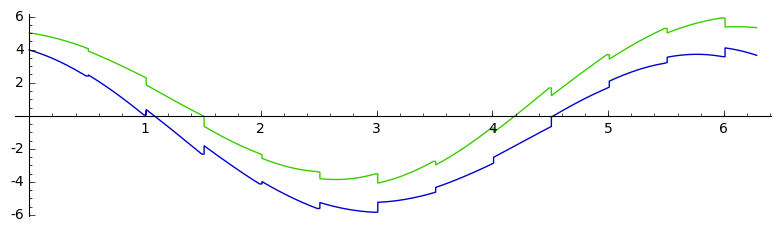

In [81]:
C0.sage_plot('x', 0.01).show(aspect_ratio=1/7)

$Y(t)$ flowpipe:

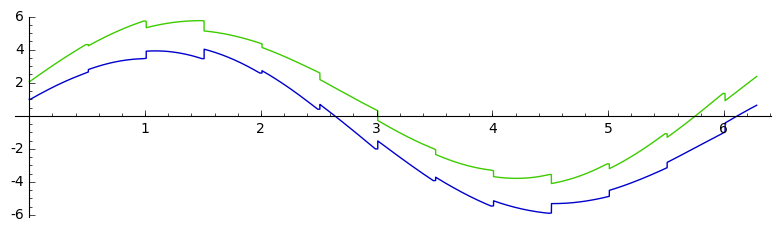

In [82]:
C0.sage_plot('y', 0.01).show(aspect_ratio=1/7)

$X(t), Y(t)$ octogons:

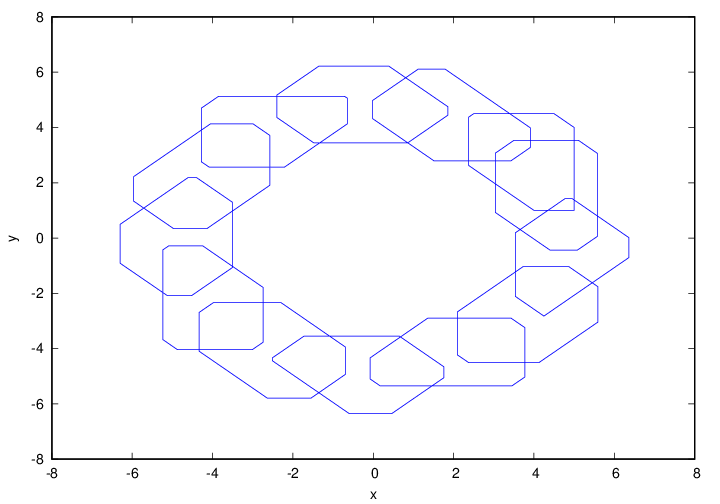

In [83]:
C0.wplot('x', 'y')

**Goal**: Does this system satisfy a spatio-temporal formulae e.g.

$$ \mathbf F_{[\pi/6,\pi/2]}([X] > 0 \Rightarrow [9,10]\,Y \triangleright \mathbf G_{[0,\pi/2]}([Y] > 0))$$

**Approach**:
 - Use flow* as a backend to extract Taylor model flowpipes:
   $$(p_1(\mathbf x,t), I_1),\; \ldots,\; (p_n(\mathbf x,t), I_n)$$
   enclosing evolution of system.
 - Build three-valued temporal signals $\varphi : \mathbb R_{\geq 0} \to \{\texttt{True}, \texttt{False}, \bot\}$ for satisfaction of temporal formulae.
     - Find signals for atomic propositions using root detection.
     - Combine signals for more complex propositions.

Context operators are more complex and will require multiple calls to flow*.

### How to call flow*?

Flow* usually runs from the command line and dumps flowpipes to disk.

Instead we directly link to Flow*'s C++ API:
 - Flowpipes stored in memory
 - Can directly query them via Flow*'s API

 Flow* wrapped in python $\texttt{Reach}$ class (via Cython):

In [84]:
variables = ['x', 'y']
odes      = [Poly(-1, 'y', 1, variables), Poly(1, 'x', 1, variables)]

C0 = Reach(
    variables,       # List of variables
    odes,            # ODEs 
    [(4,5), (1,2)],  # Initial conditions
    2*pi,            # Time horizon
    0.5,             # Step size
    order=10,        # Taylor model order
)

This allows us to do interval evaluation:

In [85]:
def show_intervals(xs):
    print '[' + ', \n '.join([x.str(style='brackets') for x in xs]) + ']'

In [86]:
(x, y) = C0((1,2))

In [87]:
(xlo, xhi) = x.endpoints()
rect = polygon([(1, xlo), (2, xlo), (2, xhi), (1, xhi)], fill=False, color='red')
p = C0.sage_plot('x', 0.01) + rect
p.set_aspect_ratio(1/4)

In [88]:
print("t in {}\nx in {}\ny in {}".format(
    RIF(1,2).str(style='brackets'),
    x.str(style='brackets'),
    y.str(style='brackets'),
))

t in [1.0000000000000000 .. 2.0000000000000000]
x in [-4.2765158639230583 .. 2.2878179688425995]
y in [2.5635778686684003 .. 6.2179798266784046]


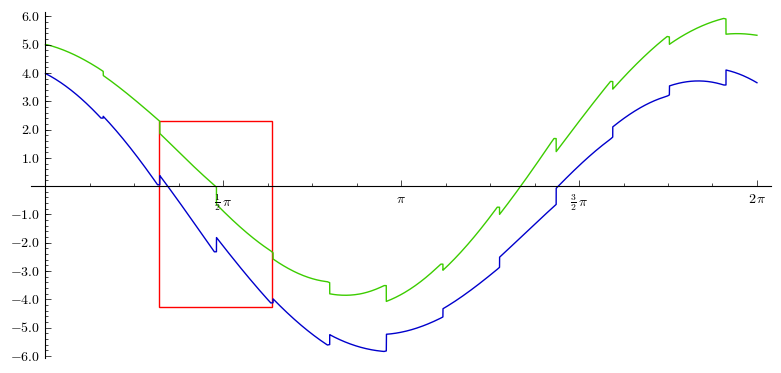

In [89]:
p.show(ticks=[pi/2, 1], tick_formatter=pi)

## Three-valued signal monitoring

We want to extract a three-valued signal
$$\varphi : \mathbb R_{\geq 0} \to \{ \texttt{True}, \texttt{False}, \bot \}$$
of a temporal logic formula over a Taylor model.

For atomic propositions
$$\varphi \triangleq g(\mathbf x) > 0$$
we use Interval-Newton iteration [1].

--- 
 1. Ishii, D., Yonezaki, N., Goldsztejn, A.: Monitoring Temporal Properties using Interval Analysis.
IEICE Transactions on Fundamentals of Electronics, Communications and Computer Sciences E99-A (2016)

In [90]:
def plot_signal(sig):
    return sig.to_domain(RIF(0,2*pi)).plot().show(
        ticks=[pi/2, 1], tick_formatter=pi, aspect_ratio=1/5)

def plot_signal2(sig, f, k):
    q = sig.to_domain(RIF(0,2*pi)).plot()
    p = plot(((lambda t: f(t).lower()),
              (lambda t: f(t).upper())),
             (0,2*pi))
    l = line([(0,k), (2*pi, k)], color='grey', linestyle='--')
    return (q + p + l).show(aspect_ratio=1/5,
                        ticks=[pi/2, 1], tick_formatter=pi)

### Method

 - Isolate roots of $f(t) = g(x(t))$ using extended Inteval-Newton iteration (extending [1]):
    * Start with whole interval $I_0 = [l_0, u_0]$
    * Iterate
    $$
    I_{k+1} := \left(l_k - \frac{f(l_k)}{f(I_k)} \right) \cap I_k
    $$
    to find lower bound.
    * Find some $u_k > l_k$ past the root
    * Iterate
    $$
    I_{k+1} := \left(u_k - \frac{f(u_k)}{f(I_k)} \right) \cap I_k
    $$
    to find upper bound.

 - Construct signal by checking values in between roots.

### Guarentees

 - Guarentees correctness of signal values in between roots.
 
 - All roots contained in uncertain intervals (but not necessarily a unique root).
 
 - Flow* handles different sources of uncertainty:
     
     - Uncertain initial conditions
     
     - Uncertain time of context application
     
     - Numerical error
     
     - Uncertain rates
     
 - Truely dense time: Taylor Models enclose the behaviour in between steps.

$$ P \triangleq [\mathrm X] > 3$$

In [91]:
load('interval_signals.py')

In [92]:
P = to_signal_piecewise(f      = (lambda t: RIF(C0(t)[0]) - 3),
                        fprime = (lambda t: -RIF(C0(t)[1])),
                        time   = 2*pi,
                        step   = 0.5)
P

  I  = [0.00000000000000000 .. 0.35089922107109756]
f(I) = [-0.0096241033684574262 .. 2.0000000032591761]
  I  = [4.5000000000000000 .. 4.8605589835075032]
f(I) = [-3.6450023654962274 .. 0.031141542104110798]


Signal([0.00000000000000000 .. 6.5000000000000000], [([0.00000000000000000 .. 0.35089922107109756], True), ([0.79256174596222295 .. 4.8605589835075032], False), ([5.3487303887660386 .. 6.5000000000000000], True)])

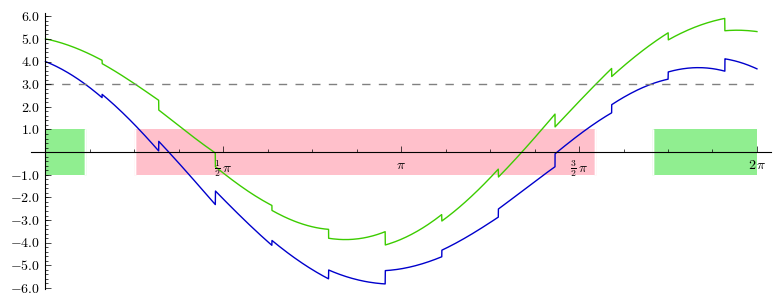

In [93]:
plot_signal2(P, lambda t: C0(t)[0], 3)

In [94]:
Q = to_signal_piecewise(f      = (lambda t: 3 - RIF(C0(t)[1])),
                        fprime = (lambda t: -RIF(C0(t)[0])),
                        time   = 2*pi,
                        step   = 0.5)

  I  = [0.00000000000000000 .. 0.20533810062921379]
f(I) = [-0.026690506136130666 .. 2.0000000033937329]
  I  = [1.5000000000000000 .. 1.8936020801902296]
f(I) = [-2.7339127685406073 .. 0.010440922408752940]
  I  = [6.0000000000000000 .. 6.4117268601091287]
f(I) = [-0.046436493851961469 .. 3.9829339344035853]


$$Q \triangleq [Y] < 3$$

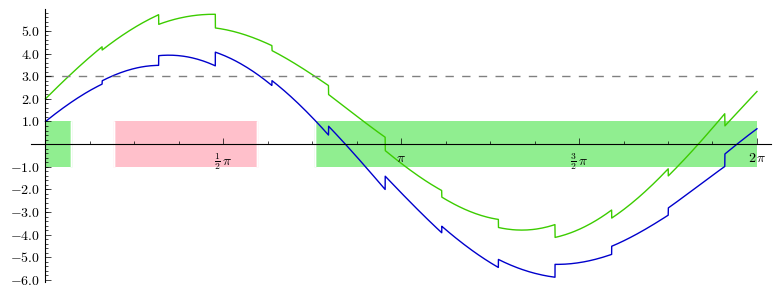

In [95]:
plot_signal2(Q, lambda t: C0(t)[1], 3)

In [96]:
C0 = Reach(
    variables,       # List of variables
    odes,            # ODEs 
    [(4,5), (1,2)],  # Initial conditions
    4*pi,            # Time horizon
    0.5,             # Step size
    order=10,        # Taylor model order
)
P = to_signal(f      = (lambda t: RIF(C0(t)[0]) - 3),
              fprime = (lambda t: -RIF(C0(t)[1])),
              domain = RIF(0,4*pi))
Q = to_signal(f      = (lambda t: 3plot_signal( (~sig | sigx).F(RIF(3*pi/12,4*pi/12)) ) - RIF(C0(t)[1])),
              fprime = (lambda t: -RIF(C0(t)[0])),
              domain = RIF(0,4*pi))

  I  = [0.00000000000000000 .. 0.35089629907625814]
f(I) = [-0.0096131327715576199 .. 2.0000000032591761]
  I  = [0.35089729907625816 .. 0.35189729907625817]
f(I) = [-0.0036930099752749968 .. 1.4204095749668416]
  I  = [0.79256016849834121 .. 4.8605579273785793]
f(I) = [-9.2982709853556039 .. 0.031135905748425508]
  I  = [4.8605589273785794 .. 4.8615589273785798]
f(I) = [-1.7046455899100870 .. 0.0052400262178116109]
  I  = [5.3487411141301777 .. 6.6419665926834571]
f(I) = [-0.12010937157864854 .. 3.3639459327338877]
  I  = [6.6419675926834571 .. 6.6429675926834575]
f(I) = [-0.0036649560932273673 .. 1.3735185757193165]
  I  = [7.0330203597871516 .. 11.200911914021774]
f(I) = [-9.3022486452362668 .. 0.025783646096133595]
  I  = [0.00000000000000000 .. 0.20533714773253159]
f(I) = [-0.026685741652719753 .. 2.0000000033937329]
  I  = [0.58650350627599090 .. 1.8935988383132323]
f(I) = [-3.2179798266784046 .. 0.087666956002709018]
  I  = [1.8935998383132324 .. 1.8945998383132326]
f(I) = [-1.5

$$\mathrel{\mathbf G}_{[1,1.2]} ([X] > 3)$$

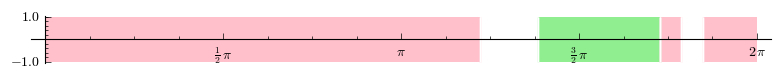

In [97]:
plot_signal( P.G(RIF(1,1.2)) )

$$\mathrel{\mathbf F}_{[3.5,4]} ([Y] < 3)$$

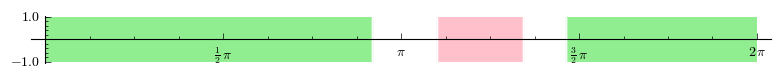

In [98]:
plot_signal( Q.F(RIF(3.5,4)) )

$$\mathrel{\mathbf G}_{[1,2]} ([X] > 3)
\vee \mathrel{\mathbf F}_{[3.5,4]} ([Y] < 3)$$

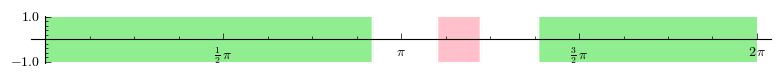

In [99]:
plot_signal( P.G(RIF(1,1.2)) | Q.F(RIF(3.5,4)) )

$$\mathrel{\mathbf G}_{[1,1.2]} ([X] > 3)
\wedge \mathrel{\mathbf F}_{[3.5,4]} ([Y] < 3)$$

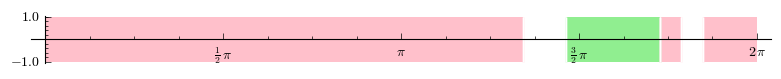

In [100]:
plot_signal( P.G(RIF(1,1.2)) & Q.F(RIF(3.5,4)) )

$$(\mathrel{\mathbf G}_{[1,1.2]} ([X] > 3))
\mathrel{\mathbf U_{[0.4,0.5]}} (\mathrel{\mathbf F}_{[3.5,4]} ([Y] < 3))$$

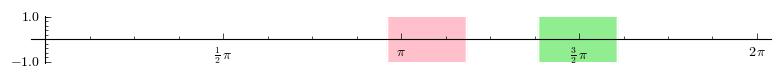

In [101]:
plot_signal( P.G(RIF(1,1.2)).U(RIF(0.4,0.5), Q.F(RIF(3.5,4))) )

## Monitoring context signal

A context operator specifies behaviour after adding a new (uncertain) process:
$$[9,10]\,Y \triangleright \mathbf G_{[0,\pi/2]}([Y] > 0)$$

In [102]:
C0 = Reach(
    variables,
    odes,
    [(4,5), (1,2)],
    2*pi/3,
    0.5,
    order=10,
)
C1 = Reach(
    variables,
    odes,
    [(RIF(x) + RIF(9,10) if i == 1 else x)
     for i, x in enumerate(C0((pi/3,2*pi/3)))],
    pi,
    0.5,
    order=10,
)

In [103]:
p = C0.sage_interval_plot('x', 'y', 0.5) \
+ C1.sage_interval_plot('x', 'y', 0.5, color='green') \
+ C0.sage_tube_plot('x', 'y', 0.5, arrows=True, joins=False, boundaries=False) \
+ C1.sage_tube_plot('x', 'y', 0.5, color='green', arrows=True, joins=False, boundaries=False) \
+ polygon([(-22,0), (7, 0), (7,-22), (-22, -22)], color='red', alpha=0.2)
p.set_aspect_ratio(1/3)

Applies a jump to the current state and then checks the new system:

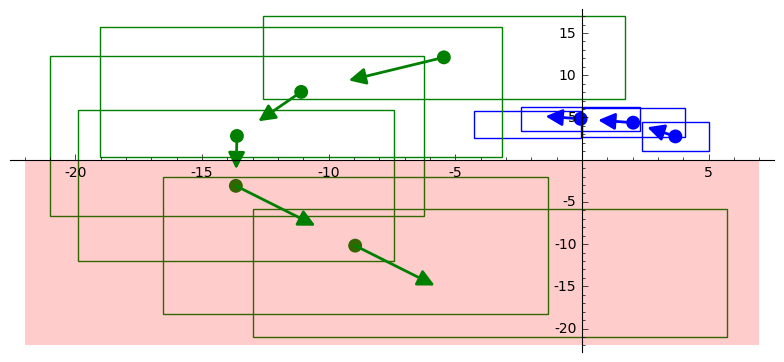

In [27]:
p

Signal of $[9,10]\,Y \triangleright \mathbf G_{[0,\pi/2]}([Y] > 0)$:

In [107]:
C0 = Reach(
    variables,
    odes,
    [(4,5), (1,2)],
    4*pi,
    0.5,
    order=10,
)

In [108]:
def continuation(xs):
    print(xs)
    return Reach(
    variables,
    odes,
    xs,
    pi,
    0.5,
    order=10,
    )

In [109]:
def phi(f):
    g = lambda t: f(t)[1]
    gprime = lambda t: f(t)[0]
    return (to_signal_bisection(g,
                     # gprime,
                      RIF(0,pi)).G(RIF(0,pi/2)))(0)

In [110]:
to_signal((lambda t: C1(t)[1]),
          (lambda t: C1(t)[0]), RIF(0,pi)).G(RIF(0,pi/2))

  I  = [0.00000000000000000 .. 1.1535682657713480]
f(I) = [-0.0052900748144317951 .. 17.012734630621087]


Signal([-1.5707963267948968 .. 3.1415926535897936], [([0.19495511294460765 .. 3.1415926535897936], False)])

In [111]:
C3 = continuation([(RIF(x) + RIF(9,10) if i == 1 else x)
                      for i, x in enumerate(C0(RIF(0, 2*pi)))])
to_signal_piecewise((lambda t: C3(t)[1]),
          (lambda t: C3(t)[0]), pi, 0.5).G(RIF(0,pi/6))

[0.?e1, 1.?e1]
  I  = [0.00000000000000000 .. 0.30050561108272312]
f(I) = [-0.00072747526879239264 .. 18.130381324891591]
  I  = [0.30050661108272314 .. 0.30150661108272315]
f(I) = [-0.011444237541442231 .. 18.050935849798972]
  I  = [3.0000010000000001 .. 3.2214030678250137]
f(I) = [-18.846109081968010 .. 0.000088779352057153557]
  I  = [3.2214040678250137 .. 3.2224040678250141]
f(I) = [-18.824609045124522 .. 0.0097849054581710775]


Signal([-0.52359877559829904 .. 3.5000000000000000], [([-0.22309216451557590 .. 0.30150661108272315], False), ([2.4764022244017009 .. 3.2224040678250141], False)])

In [112]:
C3 = continuation([(RIF(x) + RIF(9,10) if i == 1 else x)
                      for i, x in enumerate(C0(RIF(0, 2*pi)))])
to_signal_bisection((lambda t: C3(t)[1]), RIF(0,pi)).G(RIF(0,pi/6))

[0.?e1, 1.?e1]


Signal([-0.52359877559829904 .. 3.1415926535897936], [([2.5198191075668132 .. 3.1415926535897936], False)])

[0.?e1, 1.?e1]


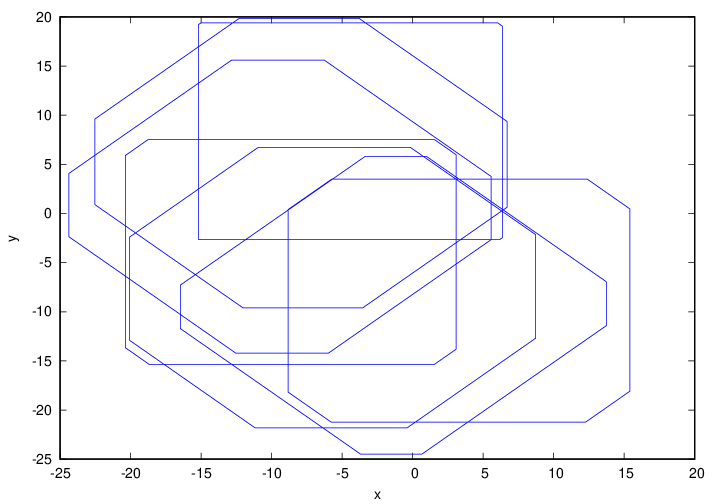

In [113]:
continuation([(RIF(x) + RIF(9,10) if i == 1 else x)
    for i, x in enumerate(C0(RIF(0, 2*pi)))]).wplot('x','y')

In [114]:
continuation([(RIF(x) + RIF(9.5,10) if i == 1 else x)
                      for i, x in enumerate(C0(RIF(0, 2*pi)))]).res

[0.?e1, 1.?e1]


2

In [115]:
load('interval_signals.py')

In [116]:
sig = ctx(
    I=RIF(0,4*pi),
    C=lambda xs: [(RIF(x) + RIF(9,10) if i == 1 else x)
                      for i, x in enumerate(xs)],
    phi=phi,
    f=C0,
    g=continuation,
    epsilon=0.1,
)

[0.?e1, 1.?e1]
None
bisecting [0.00000000000000000 .. 12.566370614359175] -> [0.00000000000000000 .. 6.2831853071795872], [6.2831853071795871 .. 12.566370614359175]
[0.?e1, 1.?e1]
None
bisecting [0.00000000000000000 .. 6.2831853071795872] -> [0.00000000000000000 .. 3.1415926535897936], [3.1415926535897935 .. 6.2831853071795872]
[0.?e1, 1.?e1]
None
bisecting [0.00000000000000000 .. 3.1415926535897936] -> [0.00000000000000000 .. 1.5707963267948968], [1.5707963267948967 .. 3.1415926535897936]
[0.?e1, 1.?e1]
None
bisecting [0.00000000000000000 .. 1.5707963267948968] -> [0.00000000000000000 .. 0.78539816339744840], [0.78539816339744839 .. 1.5707963267948968]
[1.?e1, 1.?e1]
None
bisecting [0.00000000000000000 .. 0.78539816339744840] -> [0.00000000000000000 .. 0.39269908169872420], [0.39269908169872419 .. 0.78539816339744840]
[1.?e1, 1.?e1]
True
[1.?e1, 2.?e1]
None
bisecting [0.39269908169872419 .. 0.78539816339744840] -> [0.39269908169872419 .. 0.58904862254808633], [0.58904862254808632 .. 0

[0.?e1, 1.?e1]
None
[1.?e1, 1.?e1]
None
[1.?e1, 1.?e1]
None
bisecting [10.995574287564277 .. 12.566370614359175] -> [10.995574287564277 .. 11.780972450961727], [11.780972450961726 .. 12.566370614359175]
[1.?e1, 1.?e1]
None
bisecting [10.995574287564277 .. 11.780972450961727] -> [10.995574287564277 .. 11.388273369263003], [11.388273369263002 .. 11.780972450961727]
[1.?e1, 1.?e1]
None
bisecting [10.995574287564277 .. 11.388273369263003] -> [10.995574287564277 .. 11.191923828413640], [11.191923828413639 .. 11.388273369263003]
[1.?e1, 1.?e1]
None
bisecting [10.995574287564277 .. 11.191923828413640] -> [10.995574287564277 .. 11.093749057988959], [11.093749057988958 .. 11.191923828413640]
[1.?e1, 1.?e1]
None
[2.?, 1.?e1]
True
[1.?e1, 1.?e1]
True
[1.?e1, 1.?e1]
True
[1.?e1, 1.?e1]
True


In [117]:
sig

Signal([0.00000000000000000 .. 12.566370614359175], [([0.00000000000000000 .. 0.78539816339744840], True), ([1.5707963267948967 .. 4.1233403578366046], False), ([5.0069132916587335 .. 7.1667582410017162], True), ([7.8539816339744845 .. 10.308350894591510], False), ([11.093749057988958 .. 12.566370614359175], True)])

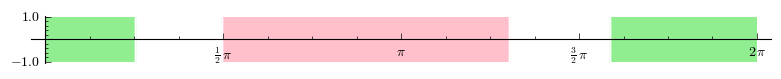

In [118]:
plot_signal(sig)

Current method: subdivide time, and monitor signal for composed system on each interval.

Can then check further temporal properties:
$$\mathbf F_{[\pi/6,\pi/2]}([X] > 0 \Rightarrow [9,10]\,Y \triangleright \mathbf G_{[0,\pi/2]}([Y] > 0))$$

In [119]:
sigx = to_signal((lambda t: C0(t)[0]), (lambda t: -C0(t)[1]), RIF(0,4*pi))

  I  = [0.00000000000000000 .. 1.0891337913457456]
f(I) = [-0.013228155874665979 .. 5.0000000032591761]
  I  = [1.3968923104058190 .. 1.3978923104058192]
f(I) = [-1.7320519564694617 .. 0.32893335267641033]
  I  = [1.4888081702090341 .. 4.2067780752321618]
f(I) = [-6.2982709853556039 .. 0.0054903619038834959]
  I  = [4.5186089876736321 .. 7.3249288928755228]
f(I) = [-0.019972578714606820 .. 6.3639459327338877]
  I  = [7.6980724668742297 .. 10.444438168421736]
f(I) = [-6.3022486452362668 .. 0.052672613202692662]


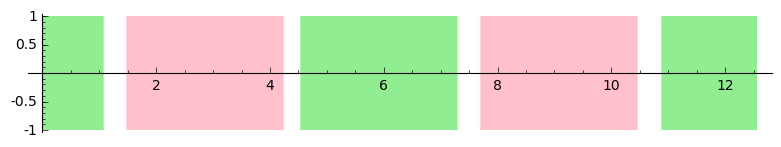

In [121]:
sigx.plot()

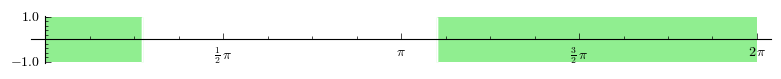

In [139]:
plot_signal( (~sigx | sig).F(RIF(pi/6,pi/2)) )

### Improving accuracy

One approach: subdivide context e.g.

$$[9,10]\,Y \triangleright \mathbf G_{[0,\pi/2]}([Y] > 0)$$
becomes
$$
([9,9.5]\,Y \triangleright \mathbf G_{[0,\pi/2]}([Y] > 0))
\wedge
([9.5,10]\,Y \triangleright \mathbf G_{[0,\pi/2]}([Y] > 0))
$$

In [40]:
sig1 = ctx(
    I=RIF(0,2*pi),
    C=lambda xs: [(RIF(x) + RIF(9,9.5) if i == 1 else x)
                      for i, x in enumerate(xs)],
    phi=phi,
    f=C0,
    g=continuation,
    epsilon=0.1,
)
sig2 = ctx(
    I=RIF(0,2*pi),
    C=lambda xs: [(RIF(x) + RIF(9.5,10) if i == 1 else x)
                      for i, x in enumerate(xs)],
    phi=phi,
    f=C0,
    g=continuation,
    epsilon=0.1,
)

[0.?e1, 1.?e1]
None
bisecting [0.00000000000000000 .. 6.2831853071795872] -> [0.00000000000000000 .. 3.1415926535897936], [3.1415926535897935 .. 6.2831853071795872]
[0.?e1, 1.?e1]
None
bisecting [0.00000000000000000 .. 3.1415926535897936] -> [0.00000000000000000 .. 1.5707963267948968], [1.5707963267948967 .. 3.1415926535897936]
[0.?e1, 1.?e1]
None
bisecting [0.00000000000000000 .. 1.5707963267948968] -> [0.00000000000000000 .. 0.78539816339744840], [0.78539816339744839 .. 1.5707963267948968]
[1.?e1, 1.?e1]
None
bisecting [0.00000000000000000 .. 0.78539816339744840] -> [0.00000000000000000 .. 0.39269908169872420], [0.39269908169872419 .. 0.78539816339744840]
[1.?e1, 1.?e1]
True
[1.?e1, 2.?e1]
None
bisecting [0.39269908169872419 .. 0.78539816339744840] -> [0.39269908169872419 .. 0.58904862254808633], [0.58904862254808632 .. 0.78539816339744840]
[1.?e1, 2.?e1]
True
[1.?e1, 2.?e1]
True
[0.?e1, 2.?e1]
None
bisecting [0.78539816339744839 .. 1.5707963267948968] -> [0.78539816339744839 .. 1.17

True
[1.?e1, 1.?e1]
True


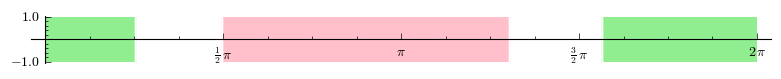

In [64]:
plot_signal(sig1 & sig2)

Effective, but rather costly. Can we do better?

Would be nice to use Newton's method rather than bisection, but have no derivative. Could we use an Interval extension of the secant method?

**A problem**:
$$[X] > 0 \Rightarrow [9,10]\,Y \triangleright \mathbf G_{[0,\pi/2]}([Y] > 0)$$

Current methods check propositions
$$[X] > 0$$
and
$$[9,10]\,Y \triangleright \mathbf G_{[0,\pi/2]}([Y] > 0)$$
independantly, whilst the constraint should rule out most of the initial set.

Idea: apply state constraints to restrict initial set (similar to HA guard intersection).

## Monitoring differential contexts

$$[0.1,0.2]\,Y \triangleright_{\partial} \mathbf G_{[0,\pi/2]}([Y] > 0)$$

**Semantics**: add $Y$ at rate $r \in [0.1, 0.2]$

**Proposed method**: After jump set
$$\begin{bmatrix}\mathrm d[X]/\mathrm dt \\ \mathrm d [Y]/\mathrm d t\end{bmatrix} = \begin{bmatrix} -[Y] \\ [X] + [0.1, 0.2] \end{bmatrix}$$

Very similar to uncertain contexts, but add uncertain input to ODEs.

Flow* can handle these via Taylor models with symbolic remainders (at the cost of more bloating of flowpipes).

## Monitoring general bounded contexts

Can we use general temporal properties as constraints on contexts?
$$([a,b]\,X \parallel [c,d]\,Y : \psi) \triangleright \varphi$$

**Semantics**: $\varphi$ in any context with bounded concentrations $X \in [a,b], Y \in [c, d]$ which satisfies $\psi$.

This give the bounded space version of Ambient Logic's *guarantee* operator.

**Approach**: subdivide context into boxes $Q = [a', b'] X \parallel [c', d'] Y$ and check
$$
    Q \models \psi \implies P \parallel Q \models \varphi 
$$

![Constrained context](images/constrained-context2.png)

How scalable is this?

### Next steps

 - Apply to more interesting examples and benchmark performance.
 
 - Continue implementation and formalise semantics.
 
 - Handling of $\Rightarrow$.
  
 - Improve adaptiveness.
 
 - Differential and general bounded contexts.

### Extensions

 - Quantitative degree of satisfaction?
 
 - Combine with discrepancy functions?
 
 - Decomposition of system?